(2, 427, 640, 3)

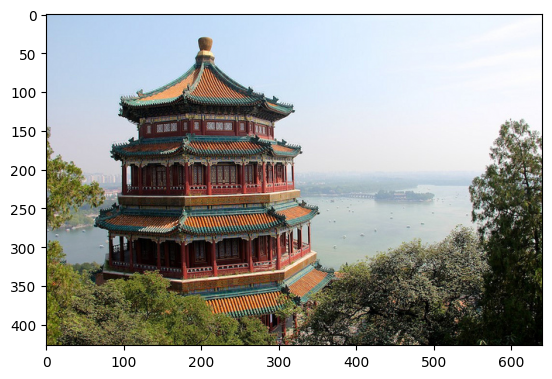

In [ ]:
 # Convolution Neural Network
# Basic Details

# An image is represented by a three dimensional tensor with dimension (height, width, channel),
# channel for grey scale images are one and for colorful images it's generally 3 (Red, Green, Blue),
# for some images like satelite images the channels are 4 with a layer for infrared, Fixing a
# channel we have (height, width), if height is h so basiaclly the tensor has h rows
# (note: after fixing the channel) and w columns for w width.

# An image is represented by a three dimensional tensor with dimension (height, width, channel),
# channel for grey scale images are one and for colorful images it's generally 3 (Red, Green, Blue),
# for some images like satelite images the channels are 4 with a layer for infrared, Fixing a
# channel we have (height, width), if height is h so basiaclly the tensor has h rows
# (note: after fixing the channel) and w columns for w width.

# A filter for forming convolution layer is of dimension (fh, fw, channel), channel is the either
# the number of channels in the image or number of channels in the previous layer which ever is applicable. Now if in the
# current, layer i want "n" channels then i need n filters (as one filter produces one layer in the
# next layer, layer is formally called feature map, so dimension of the filter tensor will be
# (fh, fw, channels, fn) where fn is the number of feature maps required in the next layer.
# Now a batch of images is processed, so the batch of image will be a 4D tensor with dimesion
# (batch_size, height, width, channels). Now corresponding to each feature map there is a bias
# team so it has dimension "fn". Now these filters do not need manually building nor the biases.
# They are learnt by the model so the number of trainable parameters would be #trainable_parameter = fn*(1+fh*fw*channels)

# Now lets try to build a filter and try to pass two images through it

import sklearn
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Load sample image
china = load_sample_image("china.jpg")/255.0
flower = load_sample_image("flower.jpg")/255.0

images = np.array([china, flower])
batch_size, height, width, channels = images.shape
plt.imshow(china)
images.shape


(2, 427, 640, 2)


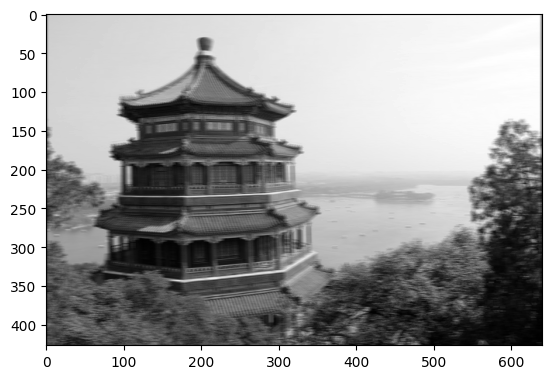

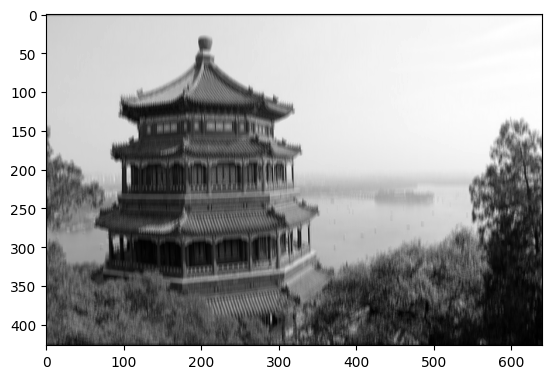

In [ ]:
# Create 2 filters (recall filter size: (fh, fw, channels, fn), fn is number of filter here fn=2)

filters = np.zeros((7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")
print(outputs.shape)
# Output is the a four dimesnional tesnor, the shape is (batch_size, height, width, #features) ie image*filter or (batch_size, "height, width, channel")*("height, width, channel", #filters) = (batch_size, height, width, #features) {basiaclly (height, width, channel)*(height, width, channel) collapses to becomes (height, width)}
plt.imshow(outputs[0, :, :, 1], cmap = "gray") # This plots first image second feature map
plt.show()
plt.imshow(outputs[0, :, :, 0], cmap = "gray") # This plots first image first feature map
plt.show()

# A conclusion after experimentation is that, one can print an image of either 3 channels or 1 channel
# not of 2 channels, in order to print one channel imgae specify cmap as gray

In [ ]:
# But we dont need to construct filters on our own to extract features, instead that is
# learnt through backporp, we just decide the dimension of the filters
# (kernel sizes(fh, fw),channel (prefixed), we decide = #filter) and the network
# learns the best weights in order to learn the filter whihc could extract the most useful feature.

# The command to generate the conv layer with such filter is done as follows (using keras)

conv = keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = "same", activation = "relu") # here kernel size of 3 means fh=fw=3
# Here we had only stated the number of filters, kernel size of 3 fixes height and width equal to 3, we did not talk about channels as its fixed from the previos layer itself.

# Next we learn how to build pooling layer

max_pool = keras.layers.MaxPool2D(pool_size = 2) # the pool_size of 2 here creates pooling block of 2*2 with the default stride equal to pool size which would be 2.

avg_pool = keras.layers.AvgPool2D(pool_size = 2) # the pool_size of 2 here creates pooling block of 2*2 with the default stride equal to pool size which would be 2.

# Keras does not have depth wise pooling layer until now, depth wise pooling layer here refers to finding the max or avg operation across features not in block within a feature, this can be done using tensorflow layer as follows:

depth_wise_pool = tf.nn.max_pool(images, ksize = (1,1,1,3), strides = (1,1,1,3), padding = "VALID") # Herre (1,1,1,3) refers to block of 1 across batch, height and width

# If we want to this layer in our keras model, we need to wrap it lambda layer of keras which can be done as follows:

keras_depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize = (1,1,1,3), stride = (1,1,1,3), padding = "valid"))

# Another type of pooling layer is global average pooling layer, it works differently, what it does it average
# entire feature map (basiaclly like an average pooling with pool size equal to (height, width) of the feature).
# Basically its output will have dimension (batch_size, 1,1,no. of features in the layer) basiaclly can be thought
# as a 1d array with dimension #features for every image. It can be implemented as follows:

global_average_pool = keras.layers.GlobalAvgPool2D()

# The above is equivalent to the following lambda layer in keras

global_average_pool_lambda = keras.layers.Lambda(lambda X : tf.reduce_mean(X, axis = [1,2])) # Note here X is four dimensional (batch_size, heigh, weight, fatures) that is why in order to take the vaerage across height and weight ie features for every image, the axis is mentioned as [1,2] not [0,1], as 0 is for batch size and 3 is for the featues

# For example: run this
a = tf.constant([[[1.0,2.0,3.0], [2.0,3.0,4.0]],[[2.0,2.0,2.0], [1.0,1.0,1.0]], [[1.0,2.0,7.0], [0.0,0.0,4.0]], [[1.0,-1.0,3.0], [4.0, 5.0,4.0]]])
tf.reduce_mean(a, axis = [1,2])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([2.5      , 1.5      , 2.3333333, 2.6666667], dtype=float32)>

In [ ]:
# CNN Architecture

# Typically CNN architectures stake a few convolutional layers (each one generally followed by a Relu layer), then a pooling layer, then another few convolution layers (+ReLU), then another pooling layer and so on.

# Lets build a CNN network to tackle fashion MNIST Dataset

from keras import datasets

fashion_mnist = datasets.fashion_mnist
FMNIST_data = fashion_mnist.load_data()

(X_train, y_train), (X_test, y_test) = FMNIST_data

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, strides = 1, activation = "relu", padding = "SAME", input_shape = [28,28,1]),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "SAME"),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "SAME"),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "SAME"),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = "SAME"),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation ="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation ="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation ="softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
model.fit(X_train, y_train, epochs = 30, validation_data = (X_test, y_test))


Epoch 1/30
1875/1875 [==============================] - 590s 314ms/step - loss: 0.9133 - accuracy: 0.6886 - val_loss: 0.4262 - val_accuracy: 0.8476
Epoch 2/30
1875/1875 [==============================] - 582s 310ms/step - loss: 0.5005 - accuracy: 0.8292 - val_loss: 0.3810 - val_accuracy: 0.8634
Epoch 3/30
1875/1875 [==============================] - 581s 310ms/step - loss: 0.4302 - accuracy: 0.8521 - val_loss: 0.3485 - val_accuracy: 0.8731
Epoch 4/30
1875/1875 [==============================] - 583s 311ms/step - loss: 0.3871 - accuracy: 0.8666 - val_loss: 0.3333 - val_accuracy: 0.8788
Epoch 5/30
1875/1875 [==============================] - 584s 311ms/step - loss: 0.3568 - accuracy: 0.8778 - val_loss: 0.3131 - val_accuracy: 0.8891
Epoch 6/30
1875/1875 [==============================] - 599s 319ms/step - loss: 0.3344 - accuracy: 0.8851 - val_loss: 0.3082 - val_accuracy: 0.8893
Epoch 7/30
1875/1875 [==============================] - 602s 321ms/step - loss: 0.3109 - accuracy: 0.8921 - val_

In [ ]:
from tensorflow.python.keras.layers import ZeroPadding3D
from tensorflow.python.ops.init_ops_v2 import Zeros
# Implementing ResNet

# First i will write the residual unit which has been discussed in the book the one which has a 2 convolutional units followed by BN each and there is a skip connection later

class ResUnit(keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.layers = [keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "SAME"), keras.layers.BatchNormalization(), keras.layers.ReLU(), keras.layers.Conv2D(64, 3, strides = 1, padding= "SAME"), keras.layers.BatchNormalization()]
    self.Concat = keras.layers.Concatenate()
    self.BN = keras.layers.BatchNormalization()

  def call(self, Z):
    input = Z
    for i in self.layers:
      Z = i(Z)
    Z = self.BN(Z)
    Z = self.Concat([input, Z])
    return tf.nn.relu(Z)

res_unit = ResUnit()
res_unit.call(np.array([list(china), list(flower)]))



<tf.Tensor: shape=(2, 427, 640, 67), dtype=float32, numpy=
array([[[[6.82352960e-01, 7.88235307e-01, 9.05882359e-01, ...,
          1.12097114e-01, 1.15717076e-01, 1.39533848e-01],
         [6.82352960e-01, 7.88235307e-01, 9.05882359e-01, ...,
          1.40443698e-01, 3.65777723e-02, 8.05917904e-02],
         [6.82352960e-01, 7.88235307e-01, 9.05882359e-01, ...,
          1.76812693e-01, 2.97286212e-02, 9.98451412e-02],
         ...,
         [9.80392158e-01, 9.84313726e-01, 1.00000000e+00, ...,
          2.49208242e-01, 1.34897502e-02, 1.30940095e-01],
         [9.80392158e-01, 9.84313726e-01, 1.00000000e+00, ...,
          3.04340065e-01, 1.73907019e-02, 1.67185932e-01],
         [9.80392158e-01, 9.84313726e-01, 1.00000000e+00, ...,
          2.12675154e-01, 0.00000000e+00, 0.00000000e+00]],

        [[6.74509823e-01, 7.80392170e-01, 8.98039222e-01, ...,
          7.46870786e-02, 1.02293678e-01, 1.94999918e-01],
         [6.78431392e-01, 7.84313738e-01, 9.01960790e-01, ...,
        

In [ ]:
# Lets experiment the result when padding is "same" with stride >1

lay = keras.layers.Conv2D(1, kernel_size = 7, strides = 3, padding ="valid")
print(lay(np.array([list(china)])))

# Basically the the padding = "same" means all the layers will be utilized, if necessary the height and width will be padded with number of layers less than the filter_size to ensure all the layers are utilized and then one can, so in this case the formula for height would be least_integer(1 + ((n - f)/s))
# when padding is valid then the height/width would be greatest_integer((n-f)/s) + 1

# The above formula doesn't seem to be true though, will explore it later probable formula is i guess min (p>=1) ((n+2p-f)/s) + 1

tf.Tensor(
[[[[ 0.28141585]
   [ 0.28639132]
   [ 0.2835585 ]
   ...
   [ 0.20976108]
   [ 0.20307621]
   [ 0.2058759 ]]

  [[ 0.2782686 ]
   [ 0.2801514 ]
   [ 0.28014135]
   ...
   [ 0.20513442]
   [ 0.2100113 ]
   [ 0.20925885]]

  [[ 0.28654838]
   [ 0.28155017]
   [ 0.27693847]
   ...
   [ 0.20850909]
   [ 0.21029925]
   [ 0.20640275]]

  ...

  [[-0.1412409 ]
   [-0.17917039]
   [ 0.0626454 ]
   ...
   [-0.00105147]
   [-0.02200212]
   [-0.01213986]]

  [[-0.09362796]
   [-0.11566097]
   [-0.1048776 ]
   ...
   [ 0.02671794]
   [-0.03870061]
   [-0.02364947]]

  [[-0.23461927]
   [-0.1940295 ]
   [-0.15501952]
   ...
   [ 0.02477305]
   [-0.04007582]
   [ 0.00343133]]]], shape=(1, 141, 212, 1), dtype=float32)


In [ ]:
# Implementation of ResNet as per the book

class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides = 1, activation = "relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.layers = [keras.layers.Conv2D(filters, kernel_size = 3, strides = strides, padding="same", use_bias = False),
                   keras.layers.BatchNormalization(),
                   self.activation,
                   keras.layers.Conv2D(filters, kernel_size =3, strides = 1, padding="same", use_bias = False)]
    self.skip_layer = []
    if strides>1:
      self.skip_layers = [keras.layers.Conv2D(filters, kernel_size = 3, strides = strides, padding="same", use_bias = False),
                          keras.layers.BatchNormalization()]

  def call(self, inputs):
    Z = inputs
    for layers in self.main_layers:
      Z = layers(Z)
    skip_Z = Z
    for layers in self.skip_layers:
      sikp_Z = layers(skip_Z)
    return self.activation(Z+skip_Z)

# Now we will build the ResNet as using the sequential api

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [224, 224, 3], padding = "same", use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides =2, padding = "same"))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
  strides = 1 if filters = prev_filter else 2
  model.add(ResidualUnit(filters, strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

images

In [ ]:
# Using keras pretrained models

# In general we dont need to implement standard models like GoogLeNet, ResNet etc manually, since pre-trained networks are readily avaiable
# with a single line of code in the keras.applications package. For example we load resnet 50 using the below code

model = keras.applications.resnet50.ResNet50(weights = "imagenet")

# This is all, we have created the resnet 50 model having weights on the ImageNet dataset. To use it we need to
# ensure images have right size. A ResNet-50 model expects 224*224 pixel images, so let's use Tensorflow's tf.images.resize
# to resize the images

images_resized = tf.images.resize(images, [224,224])

# The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0
# to 1, or –1 to 1, and so on. Each model provides a preprocess_input()function that you can use to preprocess your images.
#  These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range):

inputs = keras.applications.resnet50.preprocess_input(images_resized*255)

# Now we can use pre-trained model to make predictions

Y_proba = model.predict(inputs)

# As usual, the output is a matrix with one row per image and one column per class (in this case, there are 1,000 classes).
# If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, use the
# decode_predictions() function. For each image, it returns an array containing the top K predictions,
# where each prediction is represented as an array containing the class identifier, its name, and the corresponding confidence score:

top_K = keras.applications.resnet50.decode_predictions(Y_proba, top = 3)
print(top_K)




In [ ]:
# Pretrained models for transfer learning learning

# If you want to build an image classifier but you do not have enough training data,
# then it is often a good idea to reuse the lower layers of a pretrained model, as we
# discussed in Chapter 11. For example, let’s train a model to classify pictures of flowers,
# reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets (see Chapter 13):

# This will give us some practice of loading datasets with tensorflow too

import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised = True, with_info = True)
